In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata.logging

import mubind.pl
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

import seaborn

import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

Using device: cuda:0
Using device: cuda:0


In [3]:
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'

In [4]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [5]:
pwms = mb.datasets.archetypes()
clu = mb.datasets.archetypes_clu()
anno = mb.datasets.archetypes_anno()


# motifs loaded 2179


The main motifs will be the seed ones

In [6]:

pwms_by_name = {}
for k, pwm in zip(anno['Seed_motif'], pwms):
    pwms_by_name[k] = pwm

reduced_groups = [p.to_numpy() for p in pwms]
len(reduced_groups)
# #
# # for pi, p in enumerate(reduced_groups):
#     print(pi, p.shape)

286

Layer with only scATAC-seq

In [7]:
h5ad_path = '../../../../scchipseq_drosophila/s03_glue/ctcf.h5ad'

In [8]:
import scanpy as sc
adata_full = sc.read_h5ad(h5ad_path)

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


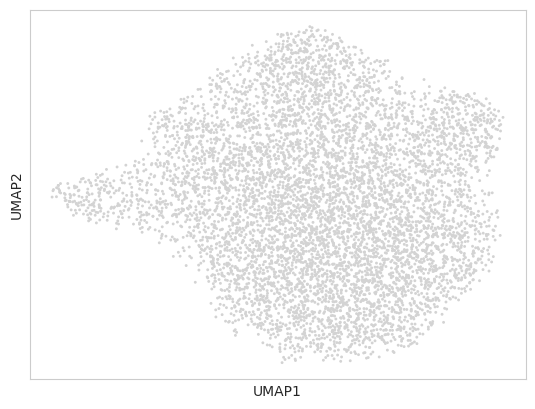

In [9]:
sc.pp.neighbors(adata_full, use_rep='X_glue')
sc.tl.umap(adata_full)

sc.pl.umap(adata_full)

In [10]:
n_sample_cells = 500 # adata.shape[0]
n_sample_peaks = n_sample_cells * 2 # adata.shape[1]

In [11]:
adata = sc.pp.subsample(adata_full, n_obs=n_sample_cells, copy=True, random_state=100)
print(adata.shape)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)
adata = adata[:,adata.var_names.isin(var_sample)].copy()
print(adata.shape)

(500, 8051)
(500, 1000)


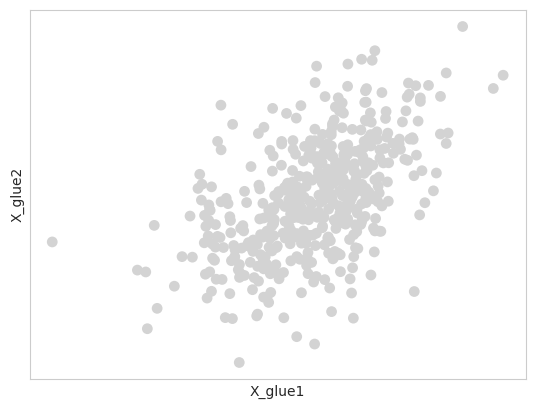

In [12]:
sc.pl.embedding(adata, basis='X_glue')

Normalize peak sequences into fixed lengths

In [13]:
adata.var['chr'] = adata.var['chrom']
adata.var['start'] = adata.var['chromStart'].astype(int)
adata.var['end'] = adata.var['chromEnd'].astype(int)

extend = 50
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

adata.var['k.summit'] = adata.var['chr'].astype(str) + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

Retrieve sequences

In [14]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/dm6/genome/dm6.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

convert bed to fasta
/tmp/tmpa6qq2d_1
genome mm10 True
../../../annotations/dm6/genome/dm6.fa
True ../../../annotations/dm6/genome/dm6.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/dm6/genome/dm6.fa -bed /tmp/tmpa6qq2d_1 -fo /tmp/tmpdplyfthc
get fasta
/tmp/tmpdplyfthc


Select peaks with non-zero counts

In [15]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

next_data = pd.DataFrame(counts)
next_data['var'] = next_data.var(axis=1)
next_data.index = [str(i) + '-' + s[1] for i, s in enumerate(seqs)]
next_data.index.name = 'seq'
print(next_data.shape)
n_cells = adata.shape[0]
n_peaks = adata.shape[1]
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_peaks]
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
del next_data_sel['var']
df = next_data_sel.copy() # sample
zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes
df.shape

print('# cells', n_cells)
print('# peaks', n_peaks)

print('selected', df.shape)

df.index = [v.split('-')[1] for v in df.index]
df.index.name = 'seq'

(1000, 501)
# cells 500
# peaks 1000
selected (986, 500)


### This is the relatedness graph and used for dynamics filters learning

In [16]:
sc.pp.neighbors(adata)
ad = adata[:,~zero_counts].copy()

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [17]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))
n_batch = len(set(dataset.batch))
n_batch

train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)


In [18]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [19]:
n_kernels = len(reduced_groups)
# n_kernels = 8

True
12
0 out of 52...
5 12 0 (5, 12) (0, 0) 1
5 12 1 (5, 12) (0, 1) 1
5 12 2 (5, 12) (0, 2) 1
5 12 3 (5, 12) (0, 3) 1
5 12 4 (5, 12) (0, 4) 1
5 12 5 (5, 12) (0, 5) 1
5 12 6 (5, 12) (0, 6) 1
5 12 7 (5, 12) (0, 7) 1
5 12 8 (5, 12) (0, 8) 1
10 out of 52...
5 12 9 (5, 12) (0, 9) 1
5 12 10 (5, 12) (0, 10) 1
5 12 11 (5, 12) (1, 11) 1
5 12 0 (5, 12) (1, 0) 1
5 12 1 (5, 12) (1, 1) 1
5 12 2 (5, 12) (1, 2) 1
5 12 3 (5, 12) (1, 3) 1
5 12 4 (5, 12) (1, 4) 1
5 12 5 (5, 12) (1, 5) 1
5 12 6 (5, 12) (1, 6) 1
20 out of 52...
5 12 7 (5, 12) (1, 7) 1
5 12 8 (5, 12) (1, 8) 1
5 12 9 (5, 12) (1, 9) 1
5 12 10 (5, 12) (1, 10) 1
5 12 11 (5, 12) (2, 11) 1
5 12 0 (5, 12) (2, 0) 1
5 12 1 (5, 12) (2, 1) 1
5 12 2 (5, 12) (2, 2) 1
5 12 3 (5, 12) (2, 3) 1
5 12 4 (5, 12) (2, 4) 1
30 out of 52...
5 12 5 (5, 12) (2, 5) 1
5 12 6 (5, 12) (2, 6) 1
5 12 7 (5, 12) (2, 7) 1
5 12 8 (5, 12) (2, 8) 1
5 12 9 (5, 12) (2, 9) 1
5 12 10 (5, 12) (2, 10) 1
5 12 11 (5, 12) (3, 11) 1
5 12 0 (5, 12) (3, 0) 1
5 12 1 (5, 12) (3, 1) 1
5 12 

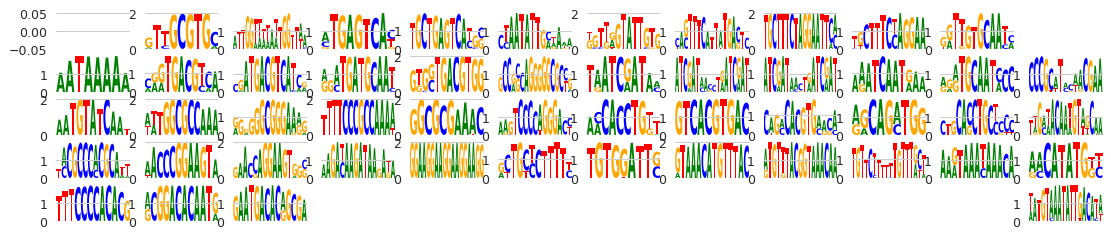

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
setting grad status of kernel (mono, dinuc) at 11 to (0, 0)
setting grad status of kernel (mono, dinuc) at 12 to (0, 0)
setting grad status of kernel (mono, dinuc) at 13 to (0, 0)
setting grad status of kernel (mono, dinuc) at 14 to (0, 0)
setting grad status of ke

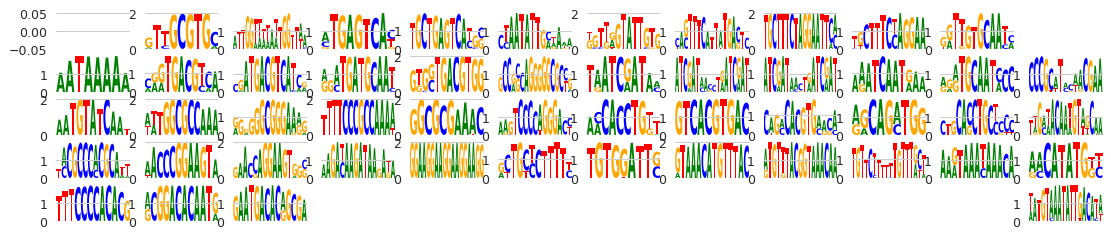

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
setting grad status of kernel (mono, dinuc) at 4 to (0, 0)
setting grad status of kernel (mono, dinuc) at 5 to (0, 0)
setting grad status of kernel (mono, dinuc) at 6 to (0, 0)
setting grad status of kernel (mono, dinuc) at 7 to (0, 0)
setting grad status of kernel (mono, dinuc) at 8 to (0, 0)
setting grad status of kernel (mono, dinuc) at 9 to (0, 0)
setting grad status of kernel (mono, dinuc) at 10 to (0, 0)
setting grad status of kernel (mono, dinuc) at 11 to (0, 0)
setting grad status of kernel (mono, dinuc) at 12 to (0, 0)
setting grad status of kernel (mono, dinuc) at 13 to (0, 0)
setting grad status of kernel (mono, dinuc) at 14 to (0, 0)
setting grad status of ke

In [20]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 150
n_epochs_kernel = 150

selected_groups = pwms[:50]

for optimize_log_dynamic in [False, True]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in selected_groups]
    model = mb.models.Multibind.make_model(train,
                                           n_kernels,
                                           criterion, kernels=[0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           dinuc_mode=None).cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(selected_groups):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=5, n_cols=12) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    if optimize_log_dynamic:
        model.selex_module.conn_sparse = torch.tensor(ad.uns['neighbors']['connectivities'].A).to_sparse().requires_grad_(True).cuda()
        model.selex_module.log_dynamic = tnn.Parameter(torch.rand(model.selex_module.conn_sparse.indices().shape[1])) # .cuda()
        model = model.cuda()
        model.selex_module.log_dynamic.shape

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1, optimiser=topti.Adam,
                                                skip_kernels=range(2, 500),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

False


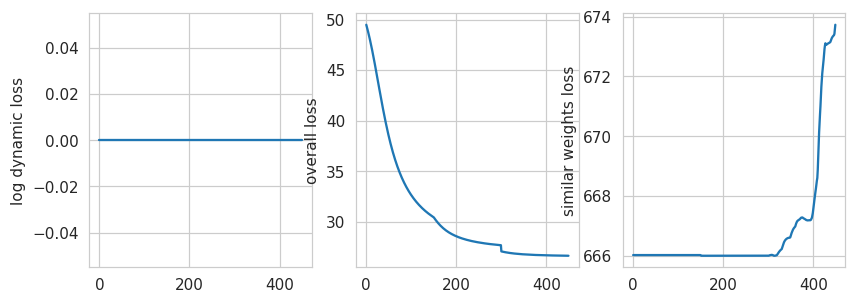

True


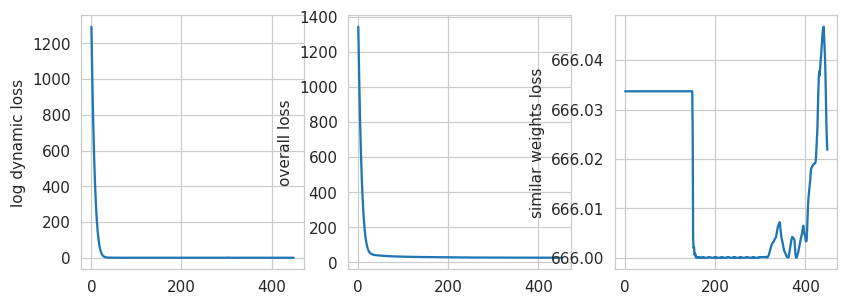

In [21]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    plt.subplot(1, 4, 1)
    plt.plot(model.loss_history_log_dynamic)
    plt.ylabel('log dynamic loss')
    plt.subplot(1, 4, 2)
    plt.plot(model.loss_history)
    plt.ylabel('overall loss')
    plt.subplot(1, 4, 3)
    plt.plot(model.loss_history_sym_weights)
    plt.ylabel('similar weights loss')
    plt.show()

False
True
8
0 out of 52...
8 8 0 (8, 8) (0, 0) 1
8 8 1 (8, 8) (0, 1) 1
8 8 2 (8, 8) (0, 2) 1
8 8 3 (8, 8) (0, 3) 1
8 8 4 (8, 8) (0, 4) 1
8 8 5 (8, 8) (0, 5) 1
8 8 6 (8, 8) (0, 6) 1
8 8 7 (8, 8) (1, 7) 1
8 8 0 (8, 8) (1, 0) 1
10 out of 52...
8 8 1 (8, 8) (1, 1) 1
8 8 2 (8, 8) (1, 2) 1
8 8 3 (8, 8) (1, 3) 1
8 8 4 (8, 8) (1, 4) 1
8 8 5 (8, 8) (1, 5) 1
8 8 6 (8, 8) (1, 6) 1
8 8 7 (8, 8) (2, 7) 1
8 8 0 (8, 8) (2, 0) 1
8 8 1 (8, 8) (2, 1) 1
8 8 2 (8, 8) (2, 2) 1
20 out of 52...
8 8 3 (8, 8) (2, 3) 1
8 8 4 (8, 8) (2, 4) 1
8 8 5 (8, 8) (2, 5) 1
8 8 6 (8, 8) (2, 6) 1
8 8 7 (8, 8) (3, 7) 1
8 8 0 (8, 8) (3, 0) 1
8 8 1 (8, 8) (3, 1) 1
8 8 2 (8, 8) (3, 2) 1
8 8 3 (8, 8) (3, 3) 1
8 8 4 (8, 8) (3, 4) 1
30 out of 52...
8 8 5 (8, 8) (3, 5) 1
8 8 6 (8, 8) (3, 6) 1
8 8 7 (8, 8) (4, 7) 1
8 8 0 (8, 8) (4, 0) 1
8 8 1 (8, 8) (4, 1) 1
8 8 2 (8, 8) (4, 2) 1
8 8 3 (8, 8) (4, 3) 1
8 8 4 (8, 8) (4, 4) 1
8 8 5 (8, 8) (4, 5) 1
8 8 6 (8, 8) (4, 6) 1
40 out of 52...
8 8 7 (8, 8) (5, 7) 1
8 8 0 (8, 8) (5, 0) 1
8 8 1 

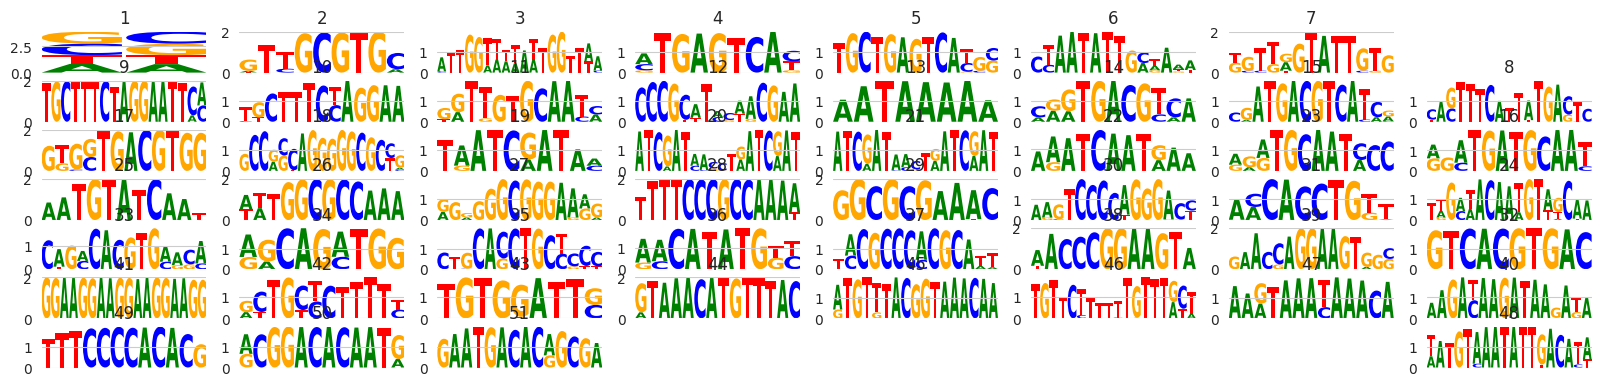

True
True
8
0 out of 52...
8 8 0 (8, 8) (0, 0) 1
8 8 1 (8, 8) (0, 1) 1
8 8 2 (8, 8) (0, 2) 1
8 8 3 (8, 8) (0, 3) 1
8 8 4 (8, 8) (0, 4) 1
8 8 5 (8, 8) (0, 5) 1
8 8 6 (8, 8) (0, 6) 1
8 8 7 (8, 8) (1, 7) 1
8 8 0 (8, 8) (1, 0) 1
10 out of 52...
8 8 1 (8, 8) (1, 1) 1
8 8 2 (8, 8) (1, 2) 1
8 8 3 (8, 8) (1, 3) 1
8 8 4 (8, 8) (1, 4) 1
8 8 5 (8, 8) (1, 5) 1
8 8 6 (8, 8) (1, 6) 1
8 8 7 (8, 8) (2, 7) 1
8 8 0 (8, 8) (2, 0) 1
8 8 1 (8, 8) (2, 1) 1
8 8 2 (8, 8) (2, 2) 1
20 out of 52...
8 8 3 (8, 8) (2, 3) 1
8 8 4 (8, 8) (2, 4) 1
8 8 5 (8, 8) (2, 5) 1
8 8 6 (8, 8) (2, 6) 1
8 8 7 (8, 8) (3, 7) 1
8 8 0 (8, 8) (3, 0) 1
8 8 1 (8, 8) (3, 1) 1
8 8 2 (8, 8) (3, 2) 1
8 8 3 (8, 8) (3, 3) 1
8 8 4 (8, 8) (3, 4) 1
30 out of 52...
8 8 5 (8, 8) (3, 5) 1
8 8 6 (8, 8) (3, 6) 1
8 8 7 (8, 8) (4, 7) 1
8 8 0 (8, 8) (4, 0) 1
8 8 1 (8, 8) (4, 1) 1
8 8 2 (8, 8) (4, 2) 1
8 8 3 (8, 8) (4, 3) 1
8 8 4 (8, 8) (4, 4) 1
8 8 5 (8, 8) (4, 5) 1
8 8 6 (8, 8) (4, 6) 1
40 out of 52...
8 8 7 (8, 8) (5, 7) 1
8 8 0 (8, 8) (5, 0) 1
8 8 1 (

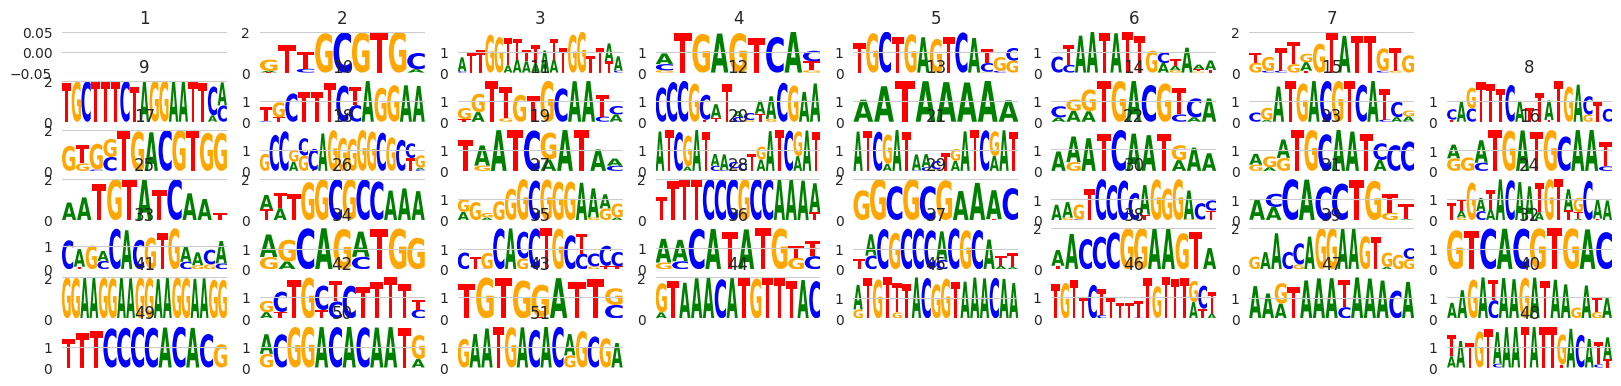

In [22]:
n_cols = int(len(model.binding_modes.conv_mono) ** .5) + 1
for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.conv(model, n_cols=n_cols, show=True, n_rows=n_cols)
    plt.show()


False
True


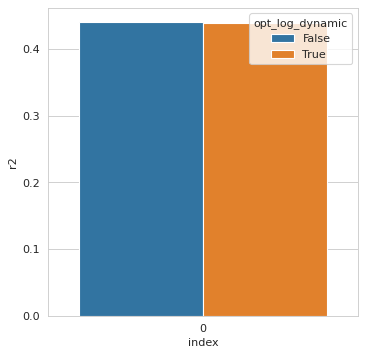

In [23]:
r2_net = None
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_net = r2 if r2_net is None else r2_net.append(r2)

rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 80
sns.barplot(data=r2_net, x='index', y='r2', hue='opt_log_dynamic')
plt.show()

In [24]:
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# connectivities
C = model.selex_module.conn_sparse
a_ind = C.indices()

log_dynamic = model.selex_module.log_dynamic
D = model.selex_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

tensor(indices=tensor([[  0,   0,   0,  ..., 425, 430, 452],
                       [ 17,  22,  57,  ..., 499, 499, 499]]),
       values=tensor([ 2.4062,  0.0692,  0.5702,  ..., -0.5036, -0.5036,
                      -0.5036]),
       device='cuda:0', size=(500, 500), nnz=25752, layout=torch.sparse_coo,
       grad_fn=<AddBackward0>)

In [25]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [26]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

Text(0.5, 7.555555555555548, 'dynamic score (normalized)')

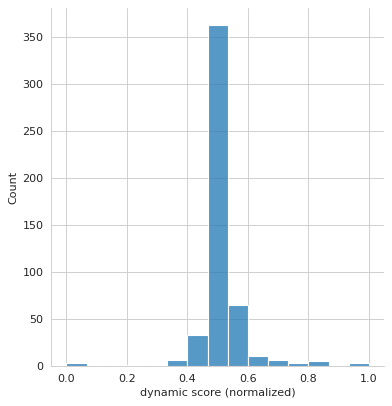

In [27]:
ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > dynamic_score.quantile(.66), 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > dynamic_score.quantile(.95), 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score, bins=15)
plt.xlabel('dynamic score (normalized)')


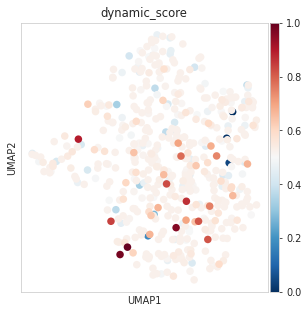

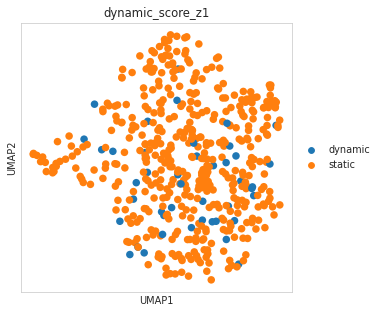

In [28]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 70
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [29]:
ad.obs['dynamic_score_z1']

barcode
CTCF_GATTCGGTCGGAGCGTCGGCGTGA     static
CTCF_GAGTATACAGAATTAGCAGTAGGC     static
CTCF_GACCTCCTGCTGATAAACACTAAG    dynamic
CTCF_GGTTAGTTACCATAATGGTCACGA     static
CTCF_GGCTGGCTGGCATAACTGGATCGA    dynamic
                                  ...   
CTCF_TTCATCGTAGAATTAGAGGTTATA     static
CTCF_TTCATCGTATGAGTAAACAGGCGC     static
CTCF_TCCATACCGGCATAACTGTAGATA     static
CTCF_TTCATCGTGGCTGCGATAAGTGGT     static
CTCF_GGAGGCCTCCATATGCACTAAGAT    dynamic
Name: dynamic_score_z1, Length: 500, dtype: category
Categories (2, object): ['dynamic', 'static']

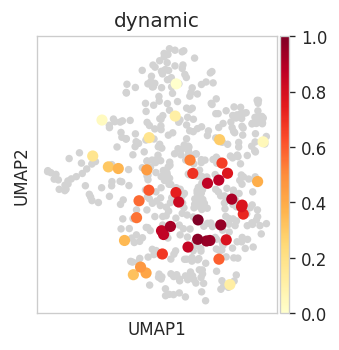

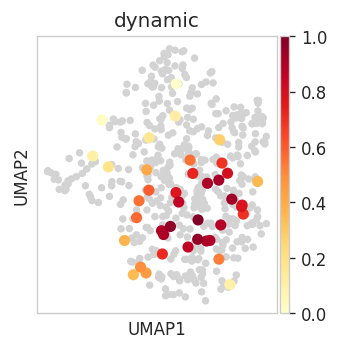

In [30]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 120

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

In [31]:
sc.set_figure_params()

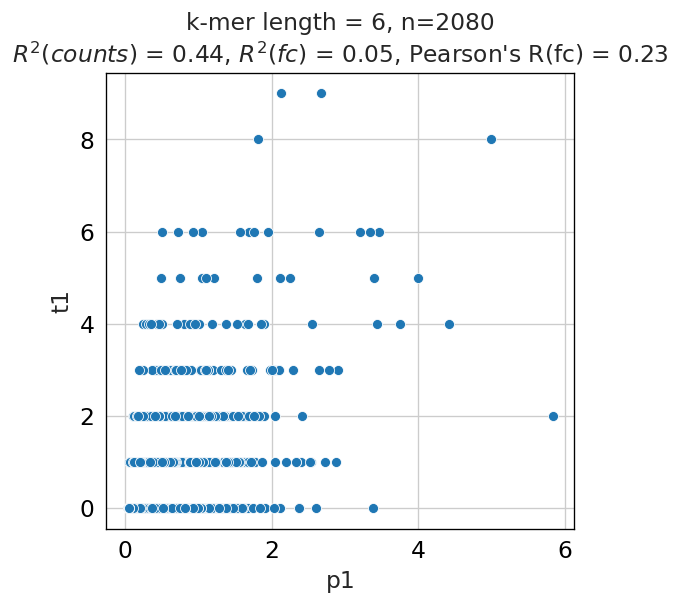

{'r2_counts': 0.43923976430176837,
 'r2_foldchange': 0.05094372770651956,
 'r2_enr': 0.07498515513984028,
 'r2_fc': 0.05265776036878025,
 'pearson_foldchange': 0.22947278786117592}

In [32]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 60})
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=6)


In [33]:
umap = ad.obsm['X_umap'].copy()
umap = np.sort(umap, 0)

x = umap[:,0]
y = umap[:,1]
X, Y = np.meshgrid(x, y)

n_points = x.shape[0]
# x-component to the right
u = np.ones((n_points, n_points))
# y-component zero
v = np.zeros((n_points, n_points))

In [34]:
D.shape

torch.Size([500, 500])

In [35]:
import scvelo as scv

In [36]:
ad.shape

(500, 986)

In [37]:
log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
log_act.shape

torch.Size([500, 52])

In [38]:
train.dataset.mononuc.shape

(986, 4, 100)

In [39]:
pred = []
for i, batch in enumerate(train):
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"].to(device)
    # print(i, mononuc.shape)
    b = batch["batch"].to(device) if "batch" in batch else None
    rounds = batch["rounds"].to(device) if "rounds" in batch else None
    countsum = batch["countsum"].to(device) if "countsum" in batch else None
    seq = batch["seq"] if "seq" in batch else None
    residues = batch["residues"].to(device) if "residues" in batch else None
    if residues is not None and train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                  "residues": residues}
    elif residues is not None:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
    elif train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
    else:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

    inputs['scale_countsum'] = model.datatype == 'selex'
    output = model(**inputs, use_conn=False)

    output = output.cpu().detach().numpy()
    print('here...')
    print(output.shape)

    print(output.sum())
    pred.append(output)

pred = np.concatenate(pred).T
ad.layers['velocity'] = pred
ad.layers['counts'] = ad.X

here...
(512, 500)
11898.999
here...
(474, 500)
11774.0


In [40]:
ad.layers['counts']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

(array([2094., 4994., 2240., 1002.,  580.,  356.,  266.,  186.,  142.,
        1016.]),
 array([0.00356356, 0.10320721, 0.20285085, 0.3024945 , 0.40213814,
        0.50178176, 0.60142541, 0.70106906, 0.8007127 , 0.90035635,
        1.        ]),
 <BarContainer object of 10 artists>)

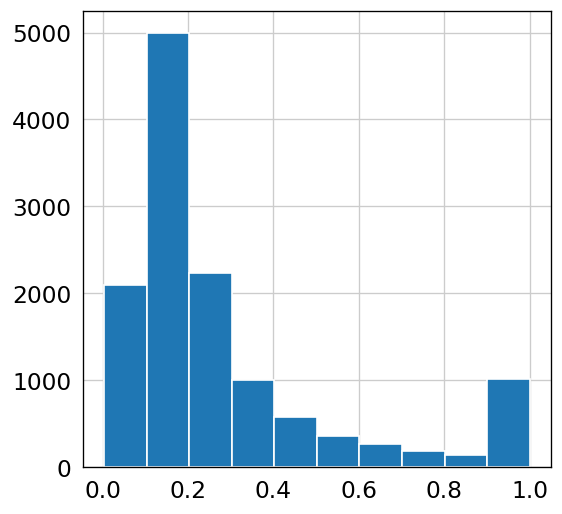

In [41]:
plt.hist(model.selex_module.conn_sparse.values().detach().cpu().numpy())

In [42]:
pred.shape

(500, 986)

In [43]:
ad.shape

(500, 986)

In [44]:
sc.pp.neighbors(ad)

In [45]:
# ad.layers['log_act'] = dyn_umap.X
# ad.layers['counts'] = ad.X
scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')

computing velocity graph (using 1/16 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


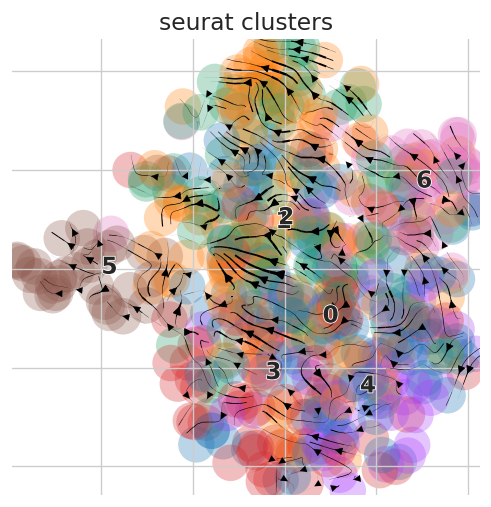

In [46]:
scv.pl.velocity_embedding_stream(ad, color='seurat_clusters') #  X_grid='X_umap', V=V)


In [47]:
ad.shape

(500, 986)

In [48]:
act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
# log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
# log_act


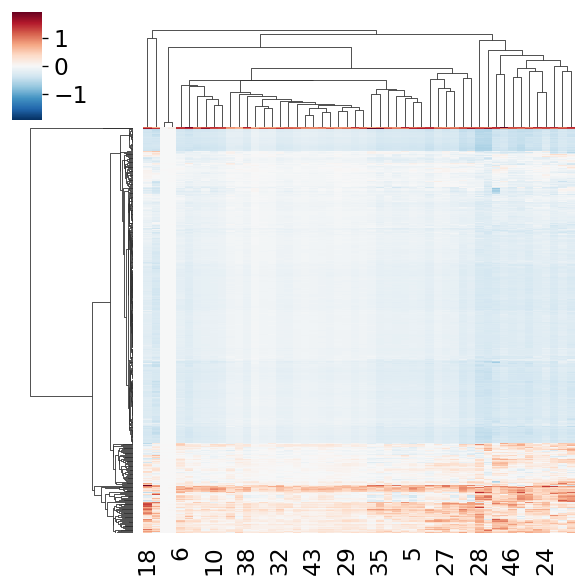

In [49]:
vmax = act.abs().max()
sns.clustermap(act.detach().cpu().numpy(), cmap='RdBu_r', vmin=-vmax, vmax=vmax, yticklabels=False, figsize=[5, 5,])

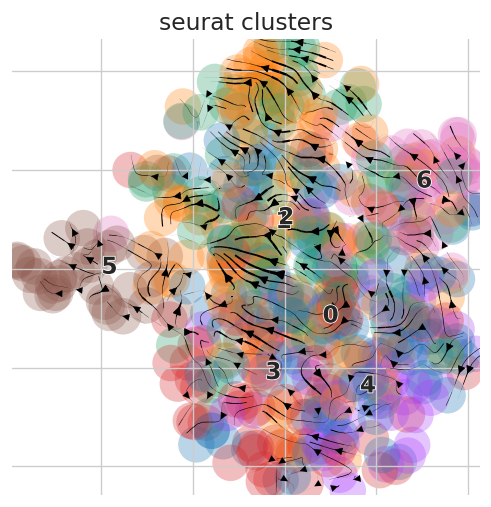

In [50]:

scv.pl.velocity_embedding_stream(ad, color='seurat_clusters') #  X_grid='X_umap', V=V)


In [51]:
log_act.shape


torch.Size([500, 52])

In [52]:
ad.shape


(500, 986)

In [53]:
log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
log_act = pd.DataFrame(log_act.detach().cpu().numpy())
# log_act.columns = anno['Seed_motif'][2]
log_act.columns = ['intercept', 'dinuc_bias'] + list(anno.head(log_act.shape[1] - 2)['Seed_motif'].values)

log_act.index = ad.obs_names
ad.obsm['mubind_activities'] = log_act
for c in ad.obsm['mubind_activities']:
    ad.obs[c] = ad.obsm['mubind_activities'][c]

Text(0.5, 1.0, 'TF modules (by score)')

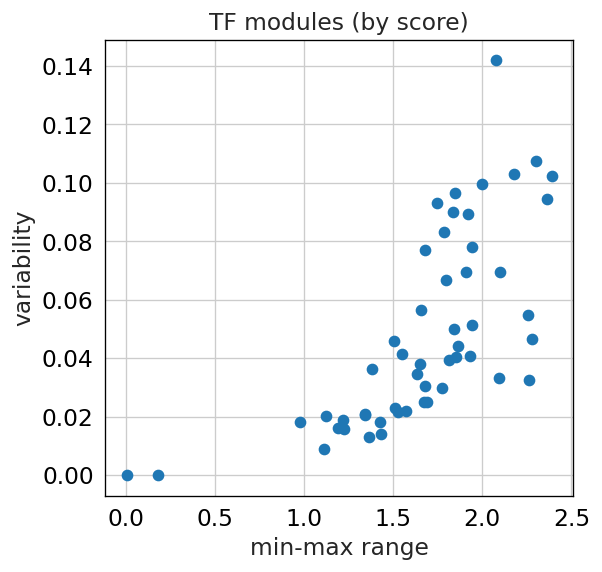

In [54]:

delta = (log_act.max(axis=0) - log_act.min(axis=0))
var = log_act.var(axis=0)
plt.scatter(delta, var)
plt.xlabel('min-max range')
plt.ylabel('variability')
plt.title('TF modules (by score)')

In [55]:
scores = pd.concat([delta, var], axis=1)
scores['combined'] = scores.sum(axis=1)
scores.sort_values('combined', ascending=False)
scores['idx'] = np.arange(scores.shape[0])

In [56]:
scores

,0,1,combined,idx
intercept,0.004620,7.845456e-08,0.004620,0
dinuc_bias,0.180313,1.091525e-04,0.180422,1
AHR_HUMAN.H11MO.0.B,1.220235,1.893613e-02,1.239171,2
AIRE_HUMAN.H11MO.0.C,1.906030,6.945374e-02,1.975484,3
ATF3_MOUSE.H11MO.0.A,1.225800,1.587247e-02,1.241672,4
BACH1_HUMAN.H11MO.0.A,1.864734,4.402341e-02,1.908758,5
Arid5a_MA0602.1,1.839738,5.003678e-02,1.889775,6
ARI5B_HUMAN.H11MO.0.C,1.632802,3.443304e-02,1.667235,7
BATF3_HUMAN.H11MO.0.B,2.256279,5.491801e-02,2.311197,8
BCL6B_C2H2_1,1.939871,7.788129e-02,2.017753,9


In [57]:
gene_query = 'CTCF'
names_query = anno[anno['Cluster_ID'].isin(set(clu[clu['Motif'].str.contains(gene_query)]['Cluster_ID'].values))]['Seed_motif'].values
names_query


array(['CTCFL_HUMAN.H11MO.0.A'], dtype=object)

In [58]:
# top_idx = scores.sort_values('combined', ascending=False).head(5).index
# idx_mb_model = scores.sort_values('combined', ascending=False).head(5)['idx'].values
top_idx = scores.head()[2:8].index
idx_mb_model = scores.head()['idx'].values[2:8]

In [59]:
idx_mb_model

array([2, 3, 4])

In [60]:
top_idx, idx_mb_model

(Index(['AHR_HUMAN.H11MO.0.B', 'AIRE_HUMAN.H11MO.0.C', 'ATF3_MOUSE.H11MO.0.A'], dtype='object'),
 array([2, 3, 4]))

In [61]:
# top_idx = [0, 1, 2, 3]

AHR_HUMAN.H11MO.0.B
AIRE_HUMAN.H11MO.0.C
ATF3_MOUSE.H11MO.0.A
0 0 (4, 9)
1 1 (4, 18)
2 2 (4, 9)


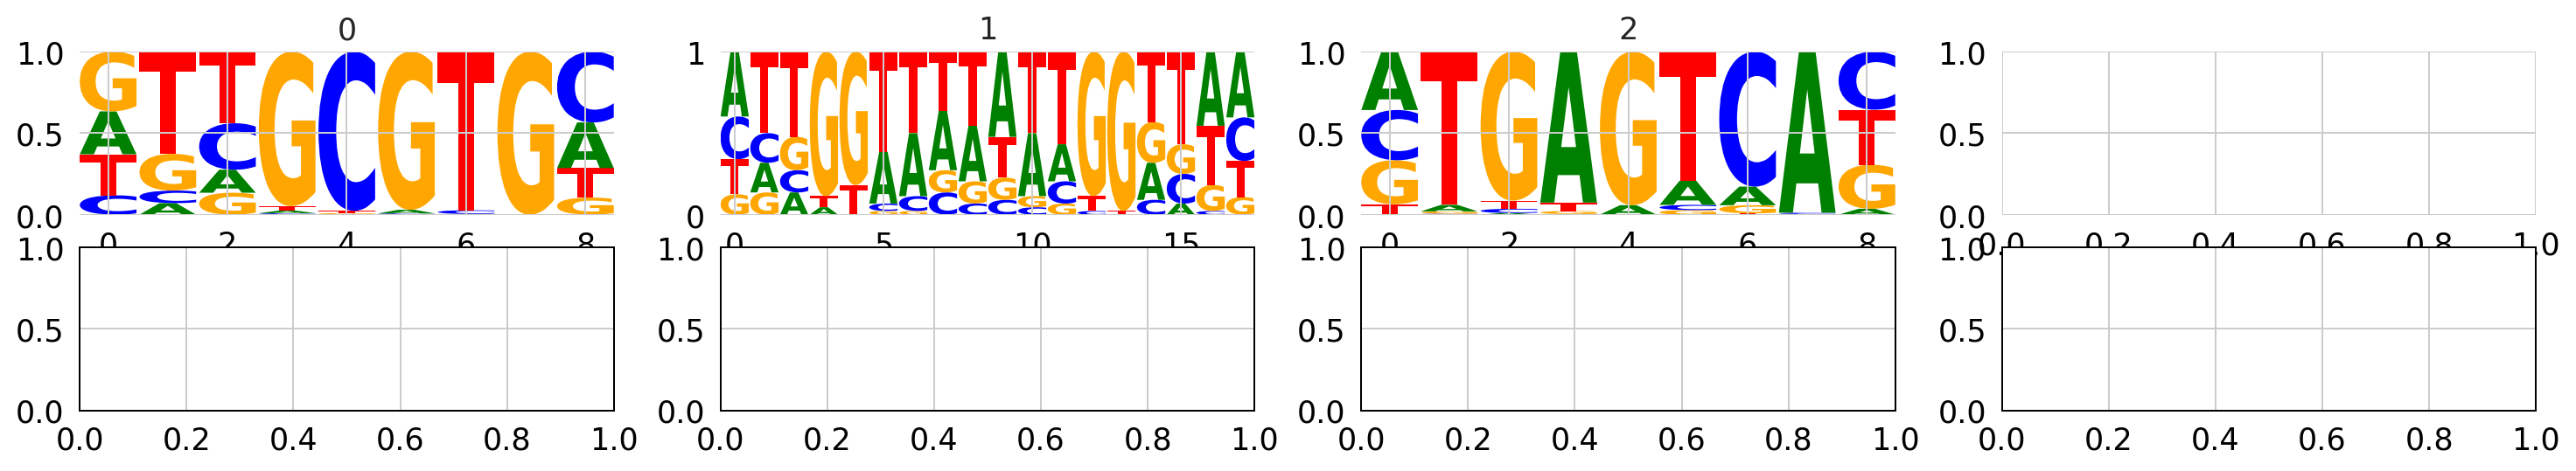

In [62]:
mb.pl.set_rcParams({'figure.figsize': [20, 3], 'figure.dpi': 90})
for k in top_idx:
    print(k)
mb.pl.conv_mono(weights_list=[pwms_by_name[k] for k in top_idx], n_cols=4, n_rows=2)

0 1 (4, 2)
1 2 (4, 9)
2 3 (4, 18)


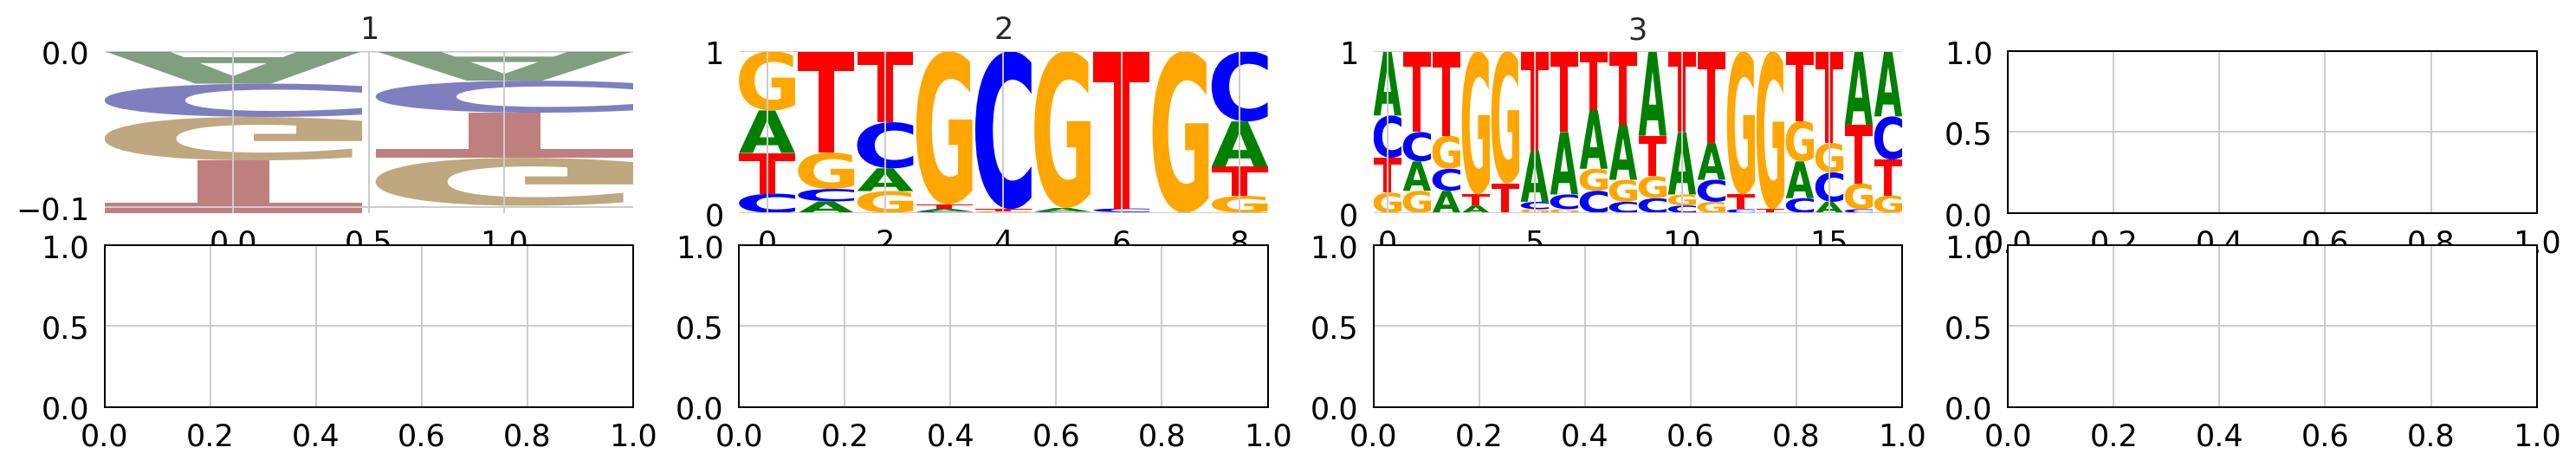

In [63]:
mb.pl.conv_mono(model, subset=[idx - 1 for idx in idx_mb_model], n_cols=4, n_rows=2)

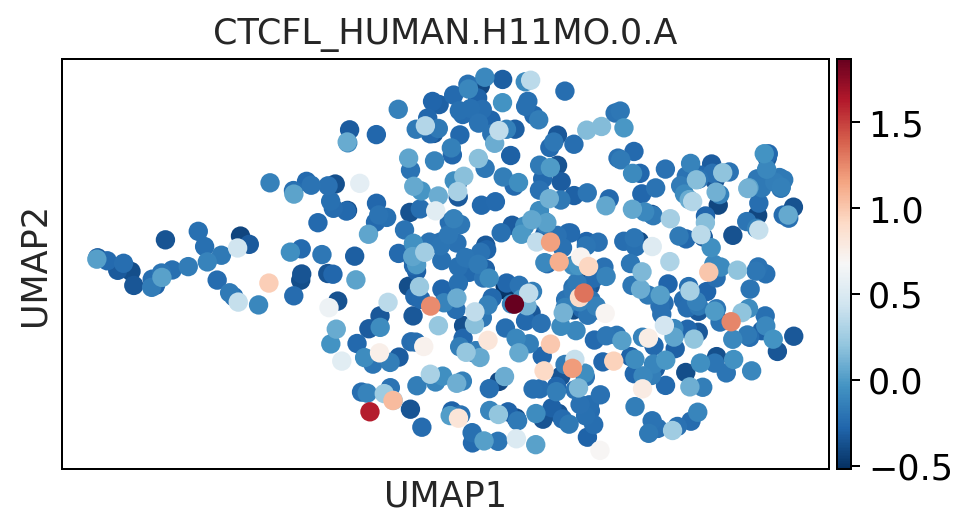

In [64]:
mb.pl.set_rcParams({'figure.figsize': [6, 3], 'figure.dpi': 90})
sc.pl.umap(ad, color=names_query, cmap='RdBu_r')

AHR_HUMAN.H11MO.0.B
AIRE_HUMAN.H11MO.0.C
ATF3_MOUSE.H11MO.0.A
0 1 (4, 2)
1 2 (4, 9)
2 3 (4, 18)


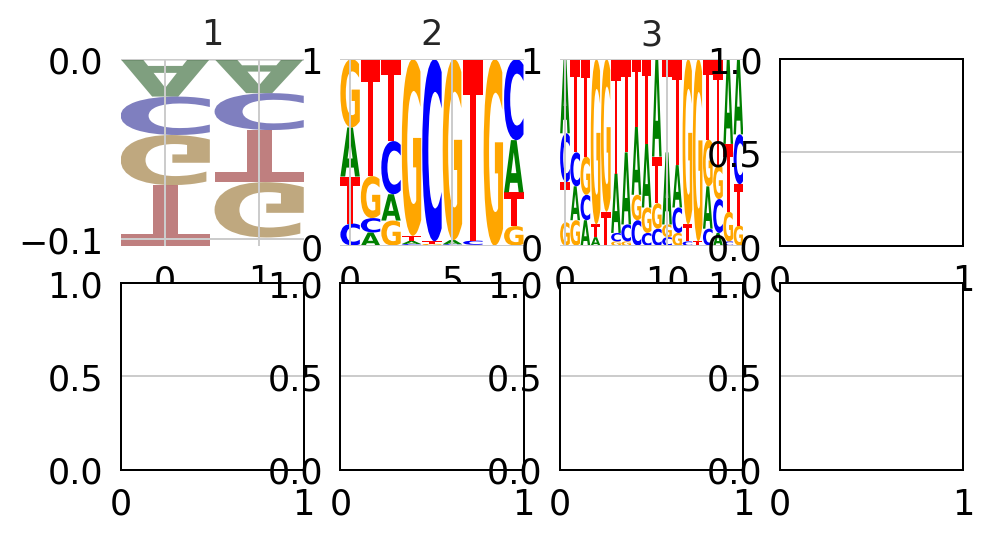

In [65]:
for k in top_idx:
    print(k)


# model
mb.pl.conv_mono(model, subset=[idx - 1 for idx in idx_mb_model], n_cols=4, n_rows=2)


In [66]:
pwms_show = [np.log2((pwms_by_name[k] + 1e-3) / (0.25) + 1e-3) for k in pwms_by_name][:20]

In [67]:
for i, pwm in enumerate(pwms_show):
    pwm[pwm < 0] = 0

0 0 (4, 9)
1 1 (4, 18)
2 2 (4, 9)
3 3 (4, 13)
4 4 (4, 14)
5 5 (4, 13)
6 6 (4, 17)
7 7 (4, 17)
8 8 (4, 13)
9 9 (4, 12)
10 10 (4, 15)
11 11 (4, 8)
12 12 (4, 11)
13 13 (4, 14)
14 14 (4, 12)
15 15 (4, 12)
16 16 (4, 17)
17 17 (4, 10)


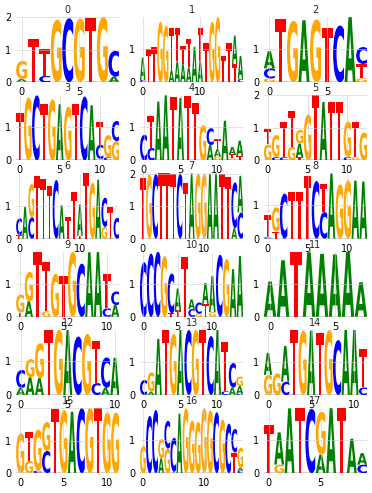

In [68]:
# original pwms
mb.pl.set_rcParams({'figure.figsize': [9, 12], 'figure.dpi': 25})
mb.pl.conv_mono(weights_list=pwms_show,
                n_cols=3, n_rows=6)

0 0 (4, 9)
1 1 (4, 18)
2 2 (4, 9)


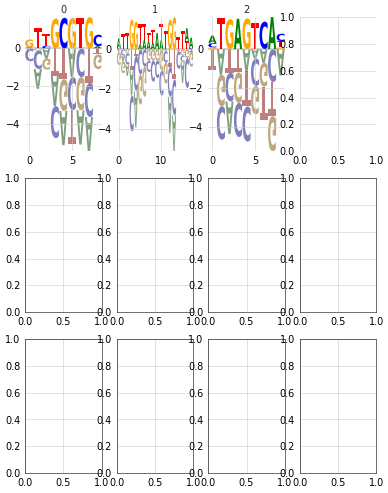

In [69]:
mb.pl.conv_mono(weights_list=[np.log2((pwms_by_name[k] + .1) / (0.25 + .1)) for k in top_idx], n_cols=4, n_rows=3)

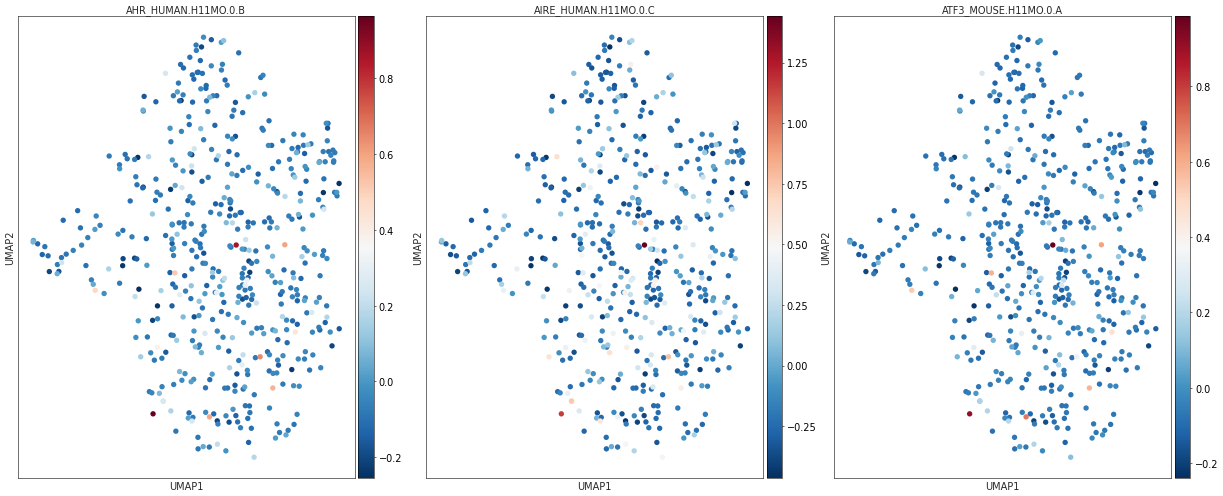

In [70]:
sc.pl.umap(ad, color=top_idx, cmap='RdBu_r')
